In [3]:
import pandas as pd 

df_train = pd.read_csv("/kaggle/input/xxxxxtrain/X_train.csv")
df_test = pd.read_csv("/kaggle/input/testxxxx/X_test.csv")

In [4]:
df_train["group"] = df_train["Id"]//257

In [5]:
#All starting positions
df_init = df_train[ df_train.index%257 == 0]

In [6]:
df_combined = df_train.merge(df_init, on="group",  suffixes=('', '_init'))

In [7]:
X = df_combined[["t","x_1_init", "y_1_init", "x_2_init", "y_2_init", "x_3_init", "y_3_init"]]

In [8]:
y = df_combined[["x_1", "y_1", "x_2", "y_2", "x_3", "y_3"]]
y

,x_1,y_1,x_2,y_2,x_3,y_3
0,1.000000,0.000000,-0.266467,0.859196,-0.733533,-0.859196
1,0.999548,0.000092,-0.266261,0.858781,-0.733287,-0.858874
2,0.998190,0.000370,-0.265641,0.857535,-0.732549,-0.857905
3,0.995925,0.000833,-0.264606,0.855456,-0.731318,-0.856289
4,0.992747,0.001483,-0.263154,0.852540,-0.729592,-0.854022
...,...,...,...,...,...,...
1284995,-0.022787,-0.354678,-0.128897,-0.618452,0.151684,0.973131
1284996,-0.082072,-0.384254,-0.084507,-0.627569,0.166578,1.011822
1284997,-0.140434,-0.438907,-0.040823,-0.610311,0.181257,1.049218
1284998,-0.177344,-0.524277,-0.018380,-0.561151,0.195724,1.085428


In [9]:
groups = df_combined["group"]
groups

0             0
1             0
2             0
3             0
4             0
           ... 
1284995    4999
1284996    4999
1284997    4999
1284998    4999
1284999    4999
Name: group, Length: 1285000, dtype: int64

In [10]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

nn = MLPRegressor(random_state=1, max_iter=3)
svm = SVR(kernel="linear")
model = LinearRegression()
model_ridge = Ridge()
model_lasso = Lasso()

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

pipe = Pipeline(
    [
            ('scaling', StandardScaler()), 
            ("model", model_ridge)
    ])
pipe

Pipeline(steps=[('scaling', StandardScaler()), ('model', Ridge())])

In [12]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GroupKFold

kfold = GroupKFold(n_splits=5)

rmse_list = [] 
y_hats = []
    
for fold_num, (train_index, test_index) in enumerate(kfold.split(X, y, groups=groups)):
    X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y.iloc[train_index], y.iloc[test_index]
    print("Fold")
    pipe.fit(X_train, y_train)
    y_hat = pipe.predict(X_test)
    y_hats.append(y_hat)
    rmse_list.append(mean_squared_error(y_test, y_hat, squared = False))

print(rmse_list)
print("AVG:", sum(rmse_list)/len(rmse_list))

Fold
Fold
Fold
Fold
Fold
[1.4325084898995037, 1.218360786183453, 1.2541316111468312, 1.1376054221164564, 1.3192516882387142]
AVG: 1.2723715995169917


In [13]:
import matplotlib.pyplot as plt
import numpy as np

def plot_y_yhat(y_test,y_pred, plot_title = "plot"):
    labels = ['x_1','y_1','x_2','y_2','x_3','y_3']
    MAX = 500
    if len(y_test) > MAX:
        idx = np.random.choice(len(y_test),MAX, replace=False)
    else:
        idx = np.arange(len(y_test))
    plt.figure(figsize=(10,10))
    for i in range(6):
        x0 = np.min(y_test[idx,i])
        x1 = np.max(y_test[idx,i])
        plt.subplot(3,2,i+1)
        plt.scatter(y_test[idx,i],y_pred[idx,i])
        plt.xlabel('True '+labels[i])
        plt.ylabel('Predicted '+labels[i])
        plt.plot([x0,x1],[x0,x1],color='red')
        plt.axis('square')
    plt.savefig(plot_title+'.pdf')
    plt.show()

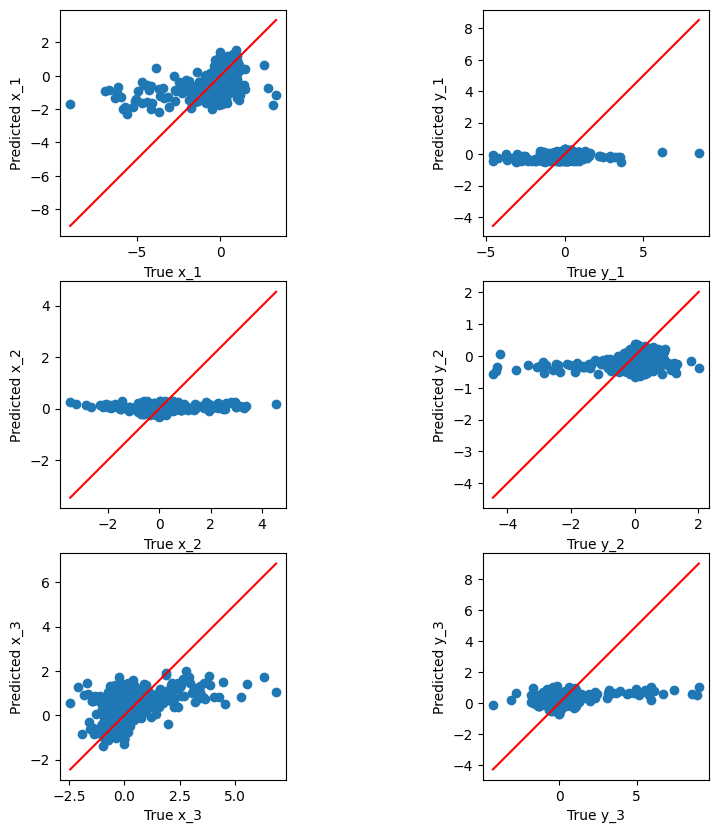

In [63]:
plot_y_yhat(y_test.to_numpy(), pd.DataFrame(y_hat).to_numpy())

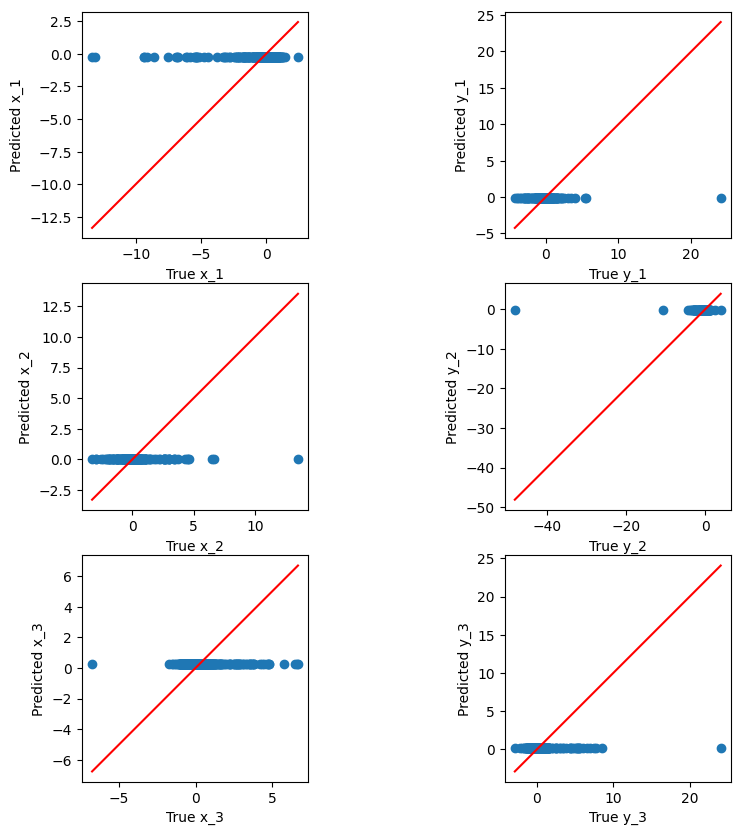

In [67]:
plot_y_yhat(y_test.to_numpy(), pd.DataFrame(y_hat).to_numpy())

In [ ]:
def validate_poly_regression(X_train, y_train, X_val, y_val, regressor=None, degrees=range(1,15), max_features=None):